### Creating a list of window coordiantes

Extent:  
99000,6702000 : 402000,6882000

In [1]:
im_path_spot_2 = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_spatial_extent(filepath):
    """
    Takes filepath, returns bounding box
    """
    
    import rasterio
    with rasterio.open(filepath) as src:
        bbox = src.bounds
    return(bbox)

In [4]:
def create_window_coordinates(filepath,window_size=500,clip=False):
    """
    Inputs:
        - fiepath: path of raster that is to be loaded by window
        - window_size: window will be pixel size NxN
        - clip: specify if every grid point should be sampled and dropped if value is invalid
    Outputs:
        - list of tuple coordinates of grid points (in CRS of input raster)
    Takes filepath, creates grid of coordinate points in wanted window size.
    (sampling of points bc mask reads whole into RAM)
    """
    
    # get bbox
    bbox = get_spatial_extent(filepath)
    left = int(bbox[0])
    bottom = int(bbox[1])
    right = int(bbox[2])
    top = int(bbox[3])
    
    # iterate in 500 steps over image bounds, create grid
    coor = []
    for i in range(left,right,window_size):
        x = i
        for j in range(bottom,top,window_size):
            y = j
            coor.append((x,y))
    
    
    """
    PERFORM CLIP
    """
    if clip:
        import geopandas
        import pandas as pd
        import rasterio
        # load into gdf
        print("performing clip of window corner points to valid raster values!\nloading points into gdf...")
        df = pd.DataFrame(coor,columns=["x","y"])
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))

        print("sampling points on raster...")
        with rasterio.open(filepath) as src:
            gdf['value'] = [sum(x) for x in src.sample(coor)]
        
        print("dropping invalid points...")
        # drop invalid points and useless columns
        gdf = gdf.drop(gdf[gdf.value <= 0].index)
        # create new list of tuples to return
        coor = []
        for x_,y_ in zip(gdf["x"],gdf["y"]):
            coor.append((x_,y_))
        print("clipping done!")
    
    return(coor)


In [5]:
def extract_spot6_window(filepath,coordinates,window_size=500,show=False):
    
    import rasterio
    import numpy as np
    
    # if coordinates == singular tuple of coordinates, wrap it in list
    if type(coordinates)!=list:
        coordinates = [coordinates]
    
    with rasterio.open(filepath) as dataset:
        # Loop through your list of coords
        for i, (lon, lat) in enumerate(coordinates):

            # Get pixel coordinates from map coordinates
            py, px = dataset.index(lon, lat)
            #print('Pixel Y, X coords: {}, {}'.format(py, px))

            # Build an NxN window (centered)
            window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
            #print(window)

            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = dataset.read(window=window)
            
            if show:
                if clip.shape == (3, 500, 500):
                    image_standard_form = np.transpose(clip, (2, 1, 0))
                    plt.imshow(image_standard_form)
                    plt.show()
                else:
                    print("Shape invalid - most likely edge window")
            
            
            """
            if save_file:
                # Set Meta of new file
                meta = dataset.meta
                meta['width'], meta['height'] = N, N
                meta['transform'] = rasterio.windows.transform(window, dataset.transform)

                with rasterio.open(outfile.format(i), 'w', **meta) as dst:
                    dst.write(clip)
            """
            
    return(clip)


In [6]:
# get coordinates
coordinates = create_window_coordinates(im_path_spot_2,window_size=500,clip=True)

performing clip of window corner points to valid raster values!
loading points into gdf...
sampling points on raster...
dropping invalid points...
clipping done!


In [7]:
%%timeit
extract_spot6_window(im_path_spot_2,coordinates[50001],window_size=500,show=False)

419 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


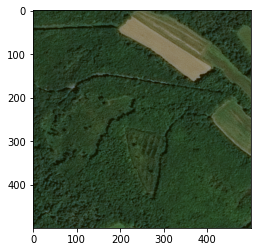

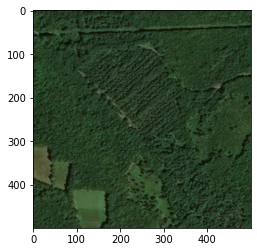

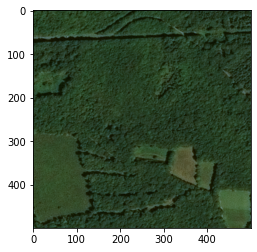

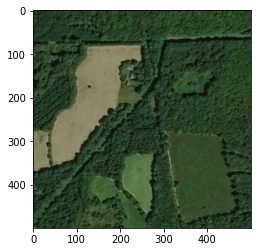

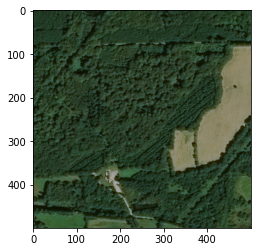

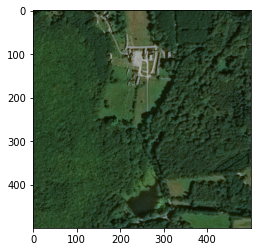

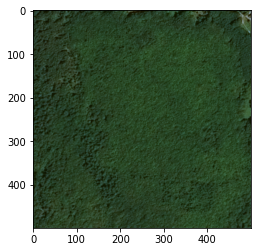

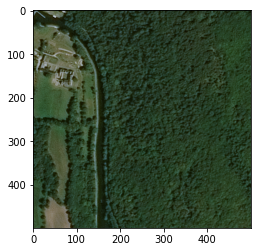

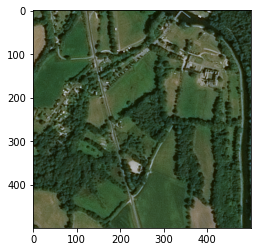

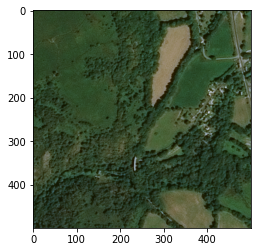

array([[[ 46,  51,  45, ...,  61,  57,  50],
        [ 46,  51,  45, ...,  58,  55,  50],
        [ 46,  49,  44, ...,  58,  58,  51],
        ...,
        [ 60,  58,  58, ...,  54,  51,  58],
        [ 64,  63,  57, ...,  45,  46,  51],
        [ 64,  61,  52, ...,  38,  38,  43]],

       [[ 69,  77,  68, ...,  87,  81,  71],
        [ 68,  76,  66, ...,  83,  77,  68],
        [ 68,  72,  67, ...,  82,  82,  72],
        ...,
        [ 88,  89,  87, ...,  79,  74,  82],
        [100,  99,  89, ...,  66,  66,  74],
        [ 99,  96,  80, ...,  54,  53,  59]],

       [[ 38,  45,  36, ...,  85,  74,  62],
        [ 37,  44,  34, ...,  77,  70,  61],
        [ 37,  40,  32, ...,  79,  77,  64],
        ...,
        [ 60,  58,  60, ...,  50,  43,  51],
        [ 75,  71,  62, ...,  37,  36,  44],
        [ 71,  70,  54, ...,  24,  20,  26]]], dtype=uint8)

In [8]:
extract_spot6_window(im_path_spot_2,coordinates[50000:50010],window_size=500,show=True)

# Define DataSet Class

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

In [10]:
# Define torch dataset Class
class Dataset(Dataset):
    def __init__(self,path,window_size=500,clip=False):
        # extract x and y as lists from DF
        self.path = path
        self.window_size = window_size
        self.coordinates = create_window_coordinates(self.path,window_size=self.window_size,clip=clip)
 
    def __len__(self):
        # returns length
        return len(self.coordinates)
 
    def __getitem__(self,idx):
        im = extract_spot6_window(self.path,self.coordinates[idx],window_size=self.window_size)
        return(im)


In [11]:
# Instanciate dataset object
dataset = Dataset(im_path_spot_2,window_size=500,clip=False)

In [25]:
# Instanciate dataloader object
loader = DataLoader(dataset,batch_size=10, shuffle=True, num_workers=3)
print("Loader Length: ",len(loader))

Loader Length:  21816


In [28]:
_ = iter(loader).next()
print(_.shape)

torch.Size([10, 3, 500, 500])


In [24]:
%%timeit
b = dataset.__getitem__(random.randint(0,10000))

3.72 s ± 439 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
